In [1]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/AxelvL/AHPQ.jl", rev="master"))
using AHPQ

   Updating git-repo `https://github.com/AxelvL/AHPQ.jl`


   Updating registry at `C:\Users\Axel9\.julia\registries\General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
No Changes to `C:\Users\Axel9\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Axel9\.julia\environments\v1.5\Manifest.toml`


## Artificial Data Generation

In [2]:
using Plots
using Statistics: norm

In [3]:
n_dp = 1000
n_dim = 16
n_queries = 100
n_neighbors = 100

data = rand(n_dim, n_dp)
data = data ./ mapslices(norm, data, dims=1)
queries = rand(n_dim, n_queries)
innerproducts = data' * queries
groundtruth = mapslices(x -> partialsortperm(x, 1:n_neighbors, rev=true), innerproducts,dims=1);

## 16x1.000 Dataset and 8x8 codebook

In [4]:
n_codebooks = 8
n_centers   = 8
recalln = 20
stopcond= 1e-2;

### Finding optimal `T`

In [5]:
Ts = 0:0.1:1
scores = zeros(11)
for i in 1:length(Ts)
    traindata=deepcopy(data)
    ahpq = builder(traindata; T=Ts[i], n_codebooks=n_codebooks, 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1)
    yhat = AHPQ.MIPS(ahpq, queries, n_neighbors)
    scores[i] = recall1atN(yhat, groundtruth, recalln)
end

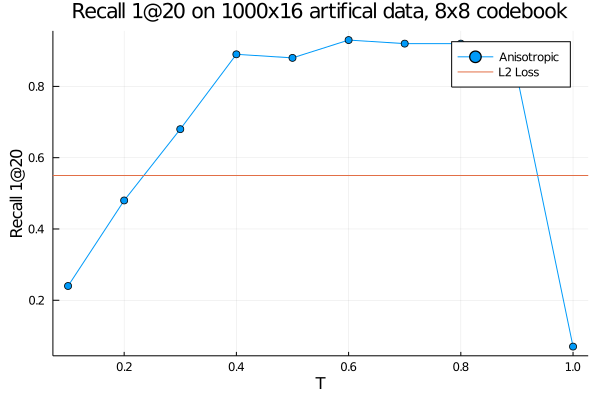

In [6]:
plot(Ts[2:end], scores[2:end], label="Anisotropic", marker=:dot)
hline!([scores[1]], label="L2 Loss")
plot!(title="Recall 1@$(recalln) on 1000x16 artifical data, $(n_codebooks)x$(n_centers) codebook", 
      xlabel="T",
      ylabel="Recall 1@$(recalln)")

### Comparison to L2 loss

In [7]:
function get1atNscores(ranking, n_neighbors, groundtruth)
    scores = zeros(n_neighbors)
    for i in 1:n_neighbors
        scores[i] = recall1atN(ranking, groundtruth, i)
    end
    return scores
end

get1atNscores (generic function with 1 method)

#### Training Tuned Anisotropic PQ

In [8]:
traindata = deepcopy(data)
ahpq = builder(traindata, T=Ts[argmax(scores)], n_codebooks=n_codebooks, 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1);
yhat = AHPQ.MIPS(ahpq, queries, n_neighbors)
anisotropic_scores  = get1atNscores(yhat, n_neighbors, groundtruth);

#### Training L2 PQ

In [9]:
traindata = deepcopy(data)
ahpq = builder(traindata, T=0, n_codebooks=n_codebooks, 
                                    n_centers=n_centers,
                                    verbose=false,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1);
yhat = AHPQ.MIPS(ahpq, queries, n_neighbors)
L2_scores  = get1atNscores(yhat, n_neighbors, groundtruth);

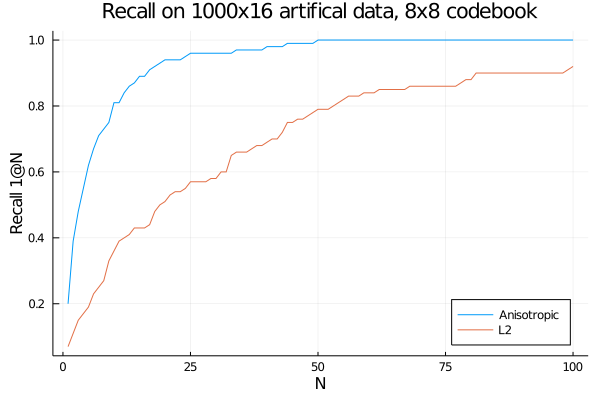

In [10]:
plot(1:100, anisotropic_scores, label="Anisotropic")
plot!(1:100, L2_scores, label="L2")
plot!(title="Recall on 1000x16 artifical data, $(n_codebooks)x$(n_centers) codebook", 
      xlabel="N",
      ylabel="Recall 1@N",
      legend=:bottomright)

## 100x1.000 Dataset: Varying `n_codebooks`

In [11]:
## Artificial Data Generation ##
n_dp = 1000
n_dim = 100
n_queries = 100
n_neighbors = 100

data = rand(n_dim, n_dp)
data = data ./ mapslices(norm, data, dims=1)
queries = rand(n_dim, n_queries)
innerproducts = data' * queries
groundtruth = mapslices(x -> partialsortperm(x, 1:n_neighbors, rev=true), innerproducts,dims=1);

In [12]:
n_centers = 16
n_codebooks = [2, 5, 10, 25, 50, 100]
nrecall = 20
stopcond=1e-3;

In [ ]:
Ts = 0.001:0.1:1
scores = zeros(11)
for i in 1:length(Ts)
    traindata=deepcopy(data)
    ahpq = builder(traindata; T=Ts[i], n_codebooks=25, 
                                    n_centers=n_centers,
                                    verbose=true,
                                    stopcond=stopcond,
                                    a=0,
                                    training_points=-1)
    yhat = AHPQ.MIPS(ahpq, queries, n_neighbors)
    scores[i] = recall1atN(yhat, groundtruth, recalln)
end
print("Optimal T found at $(Ts[argmax(scores)])")